In [494]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

sns.set_style('darkgrid')

In [495]:
START_YEAR = 2022
END_YEAR = 2022
START_MONTH = 5
END_MONTH = 12
START_DAY = 31
END_DAY = 31
LOWER_INTERVAL_BOUND = dt.datetime(START_YEAR, START_MONTH, START_DAY)
UPPER_INTERVAL_BOUND = dt.datetime(END_YEAR, END_MONTH, END_DAY)
STATES = ['CA', 'NV', 'NM', 'NJ']
NORMALIZATION_FACTOR = 1000000

In [496]:
def get_df_from_to(df, start_date=LOWER_INTERVAL_BOUND, end_date=UPPER_INTERVAL_BOUND):
    f = lambda col: col if dt.datetime.strptime(col, '%Y-%m-%d') <= end_date and dt.datetime.strptime(col, '%Y-%m-%d') >= start_date else None
    covid_recent_cols = [col for col in df.columns[:4]]
    covid_recent_cols += ([f(col) for col in df.columns[5:]])
    covid_from_to = []
    for col in covid_recent_cols:
        if col is not None:
            covid_from_to.append(col)
    return df[covid_from_to]

def normalize(df, pop, nf=NORMALIZATION_FACTOR):
    return df/pop * nf

def get_weekly_statistics(df, statistic='mean'):
    if statistic == 'mode':
        return df.groupby(df.index.isocalendar().week, axis=0).agg(lambda entry: entry.mode().to_numpy()[-1])
    elif statistic == 'median':
        return df.groupby(df.index.isocalendar().week, axis=0).median()
    elif statistic == 'mean':
        return df.groupby(df.index.isocalendar().week, axis=0).mean()
    else:
        return df.groupby(df.index.isocalendar().week, axis=0).sum()

def get_state_population(state):
    population = pd.read_csv('Team_work/data/covid_county_population_usafacts.csv')
    population = population.groupby('State').sum(numeric_only=True)
    return population.loc[state, 'population']

def get_county_population(state, countyFIPS):
    population = pd.read_csv('Team_work/data/covid_county_population_usafacts.csv')
    return population[(population['State'] == state) & (population['countyFIPS'] == countyFIPS)]['population'].values[0]

def get_county_name_by_fips(fips):
    population = pd.read_csv('Team_work/data/covid_county_population_usafacts.csv')
    return population[(population['countyFIPS'] == fips)]['County Name'].iloc[0]

def get_us_new_cases_and_deaths():
    us_covid_cases_df = get_df_from_to(pd.read_csv('Team_work/data/covid_confirmed_usafacts.csv'))
    us_covid_deaths_df = get_df_from_to(pd.read_csv('Team_work/data/covid_deaths_usafacts.csv'))
    us_covid_cases_df = us_covid_cases_df[us_covid_cases_df['countyFIPS'] != 0]
    us_covid_deaths_df = us_covid_deaths_df[us_covid_deaths_df['countyFIPS'] != 0]
    us_covid_cases_df.drop(['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1, inplace=True)
    us_covid_deaths_df.drop(['countyFIPS', 'County Name', 'State', 'StateFIPS'], axis=1, inplace=True)
    us_covid_cases_df = us_covid_cases_df.agg(np.sum, axis=0)
    us_covid_deaths_df = us_covid_deaths_df.agg(np.sum, axis=0)
    us_covid_time_series_df = pd.concat([us_covid_cases_df, us_covid_deaths_df], axis=1).diff(axis=0)
    us_covid_time_series_df.drop(us_covid_time_series_df.index[0], inplace=True)
    us_covid_time_series_df.columns = ['Cases', 'Deaths']
    us_covid_time_series_df.index = pd.to_datetime(us_covid_time_series_df.index)
    return us_covid_time_series_df

    
def get_state_new_cases_and_deaths(state):
    covid_cases_df = pd.read_csv('Team_work/data/covid_confirmed_usafacts.csv')
    covid_deaths_df = pd.read_csv('Team_work/data/covid_deaths_usafacts.csv')
    covid_cases_df = covid_cases_df[covid_cases_df['countyFIPS'] != 0]
    covid_deaths_df = covid_deaths_df[covid_deaths_df['countyFIPS'] != 0]
    covid_cases_df = get_df_from_to(covid_cases_df).drop_duplicates()
    covid_deaths_df = get_df_from_to(covid_deaths_df).drop_duplicates()
    covid_cases_ca_df = covid_cases_df.groupby('State').sum(numeric_only=True).drop(['countyFIPS', 'StateFIPS'], axis=1).reset_index()
    covid_cases_ca_df = covid_cases_ca_df[covid_cases_ca_df['State'] == state].set_index('State')
    covid_deaths_ca_df = covid_deaths_df.groupby('State').sum(numeric_only=True).drop(['countyFIPS', 'StateFIPS'], axis=1).reset_index()
    covid_deaths_ca_df = covid_deaths_ca_df[covid_deaths_ca_df['State'] == state].set_index('State')
    covid_cases_ca_weekly_df = covid_cases_ca_df.reset_index().drop('State', axis=1)
    covid_deaths_ca_weekly_df = covid_deaths_ca_df.reset_index().drop('State', axis=1)
    covid_cases_ca_weekly_df.columns = pd.to_datetime(covid_cases_ca_weekly_df.columns)
    covid_deaths_ca_weekly_df.columns = pd.to_datetime(covid_deaths_ca_weekly_df.columns)
    covid_cases_ca_weekly_df = covid_cases_ca_weekly_df.transpose()
    covid_deaths_ca_weekly_df = covid_deaths_ca_weekly_df.transpose()
    covid_deaths_ca_weekly_df.columns = ['Deaths']
    covid_deaths_ca_weekly_df['Deaths'] = covid_deaths_ca_weekly_df['Deaths'].diff().fillna(covid_deaths_ca_weekly_df['Deaths'])
    covid_cases_ca_weekly_df.columns = ['Cases']
    covid_cases_ca_weekly_df['Cases'] = covid_cases_ca_weekly_df['Cases'].diff().fillna(covid_cases_ca_weekly_df['Cases'])
    covid_time_series = pd.concat([covid_cases_ca_weekly_df, covid_deaths_ca_weekly_df], axis=1).round().astype(int)
    covid_time_series.drop(covid_time_series.index[0], inplace=True)
    return covid_time_series

In [497]:
state_1_covid_df = get_state_new_cases_and_deaths(STATES[0])
covid_time_series_mode = get_weekly_statistics(state_1_covid_df, 'mode').round()
covid_time_series_median = get_weekly_statistics(state_1_covid_df, 'median').round()
covid_time_series_mean = get_weekly_statistics(state_1_covid_df, 'mean').round()

<Axes: xlabel='week', ylabel='Deaths'>

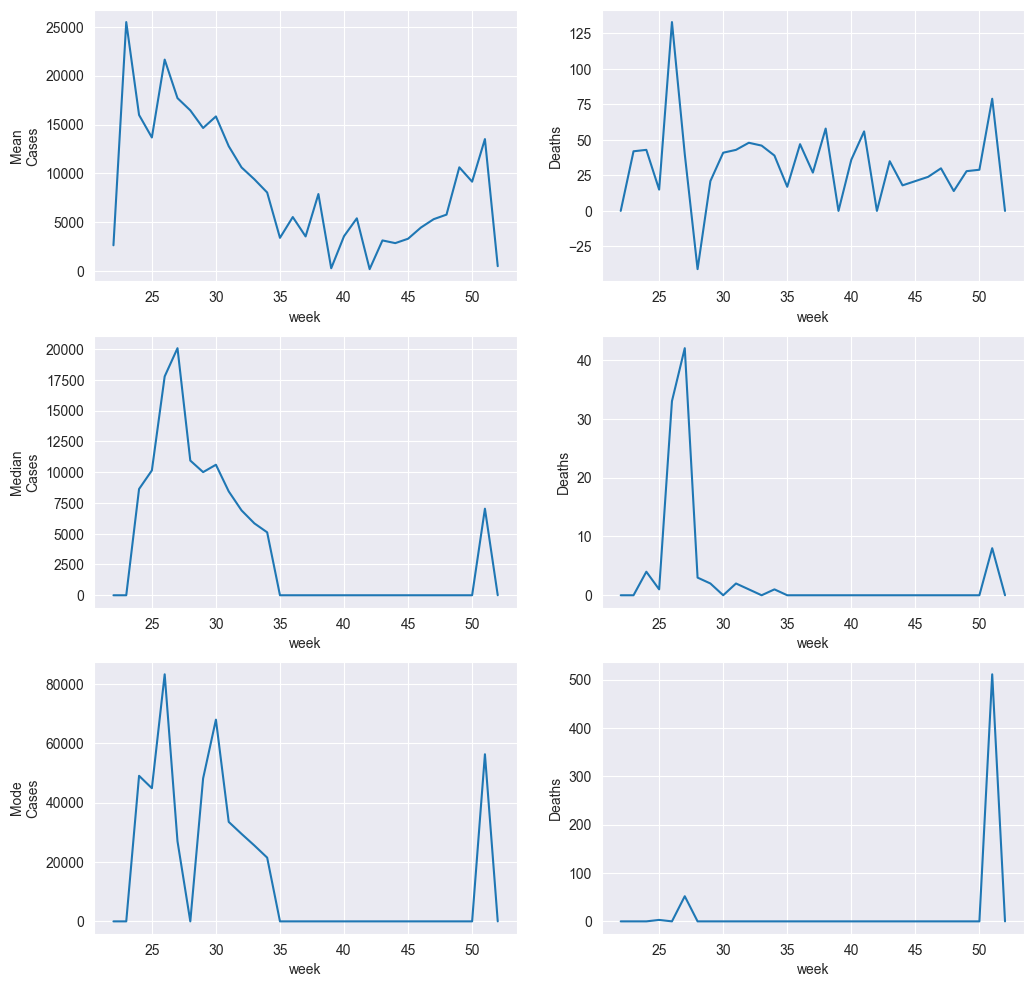

In [498]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
ax[0, 0].set_ylabel('Mean\nCases')
ax[1, 0].set_ylabel('Median\nCases')
ax[2, 0].set_ylabel('Mode\nCases')
sns.lineplot(data=covid_time_series_mean['Cases'], ax=ax[0,0])
sns.lineplot(data=covid_time_series_mean['Deaths'], ax=ax[0,1])
sns.lineplot(data=covid_time_series_median['Cases'], ax=ax[1,0])
sns.lineplot(data=covid_time_series_median['Deaths'], ax=ax[1,1])
sns.lineplot(data=covid_time_series_mode['Cases'], ax=ax[2,0])
sns.lineplot(data=covid_time_series_mode['Deaths'], ax=ax[2,1])


In [499]:
pop_df = pd.read_csv('Team_work/data/covid_county_population_usafacts.csv')
pop_df = pop_df[pop_df['countyFIPS'] != 0]
pop_state_df = pop_df.drop(['countyFIPS', 'County Name'], axis=1).groupby('State').sum()

In [500]:
state_1_covid_df = normalize(state_1_covid_df, pop_state_df.loc[STATES[0]]['population'], NORMALIZATION_FACTOR).round()
state_2_covid_df = normalize(get_state_new_cases_and_deaths(STATES[1]), pop_state_df.loc[STATES[1]]['population'], NORMALIZATION_FACTOR).round()
state_3_covid_df = normalize(get_state_new_cases_and_deaths(STATES[2]), pop_state_df.loc[STATES[2]]['population'], NORMALIZATION_FACTOR).round()
state_4_covid_df = normalize(get_state_new_cases_and_deaths(STATES[3]), pop_state_df.loc[STATES[3]]['population'], NORMALIZATION_FACTOR).round()
states_covid_cases_normalized_df = pd.concat([state_2_covid_df['Cases'], state_3_covid_df['Cases'], state_4_covid_df['Cases']], axis=1, keys=STATES[1:])
states_covid_deaths_normalized_df = pd.concat([state_2_covid_df['Deaths'], state_3_covid_df['Deaths'], state_4_covid_df['Deaths']], axis=1, keys=STATES[1:])
states_covid_cases_time_series_weekly_sum_df = states_covid_cases_normalized_df.groupby(states_covid_cases_normalized_df.index.isocalendar().week).sum()
states_covid_deaths_time_series_weekly_sum_df = states_covid_deaths_normalized_df.groupby(states_covid_deaths_normalized_df.index.isocalendar().week).sum()
states_covid_cases_time_series_weekly_mean_df = states_covid_cases_normalized_df.groupby(states_covid_cases_normalized_df.index.isocalendar().week).mean().round()
states_covid_deaths_time_series_weekly_mean_df = states_covid_deaths_normalized_df.groupby(states_covid_deaths_normalized_df.index.isocalendar().week).mean().round()
states_covid_cases_time_series_weekly_median_df = states_covid_cases_normalized_df.groupby(states_covid_cases_normalized_df.index.isocalendar().week).median().round()
states_covid_deaths_time_series_weekly_median_df = states_covid_deaths_normalized_df.groupby(states_covid_deaths_normalized_df.index.isocalendar().week).median().round()
states_covid_cases_time_series_weekly_mode_df = states_covid_cases_normalized_df.groupby(states_covid_cases_normalized_df.index.isocalendar().week).agg(lambda entry: entry.mode().to_numpy()[-1])
states_covid_deaths_time_series_weekly_mode_df = states_covid_deaths_normalized_df.groupby(states_covid_deaths_normalized_df.index.isocalendar().week).agg(lambda entry: entry.mode().to_numpy()[-1])

<Axes: xlabel='week'>

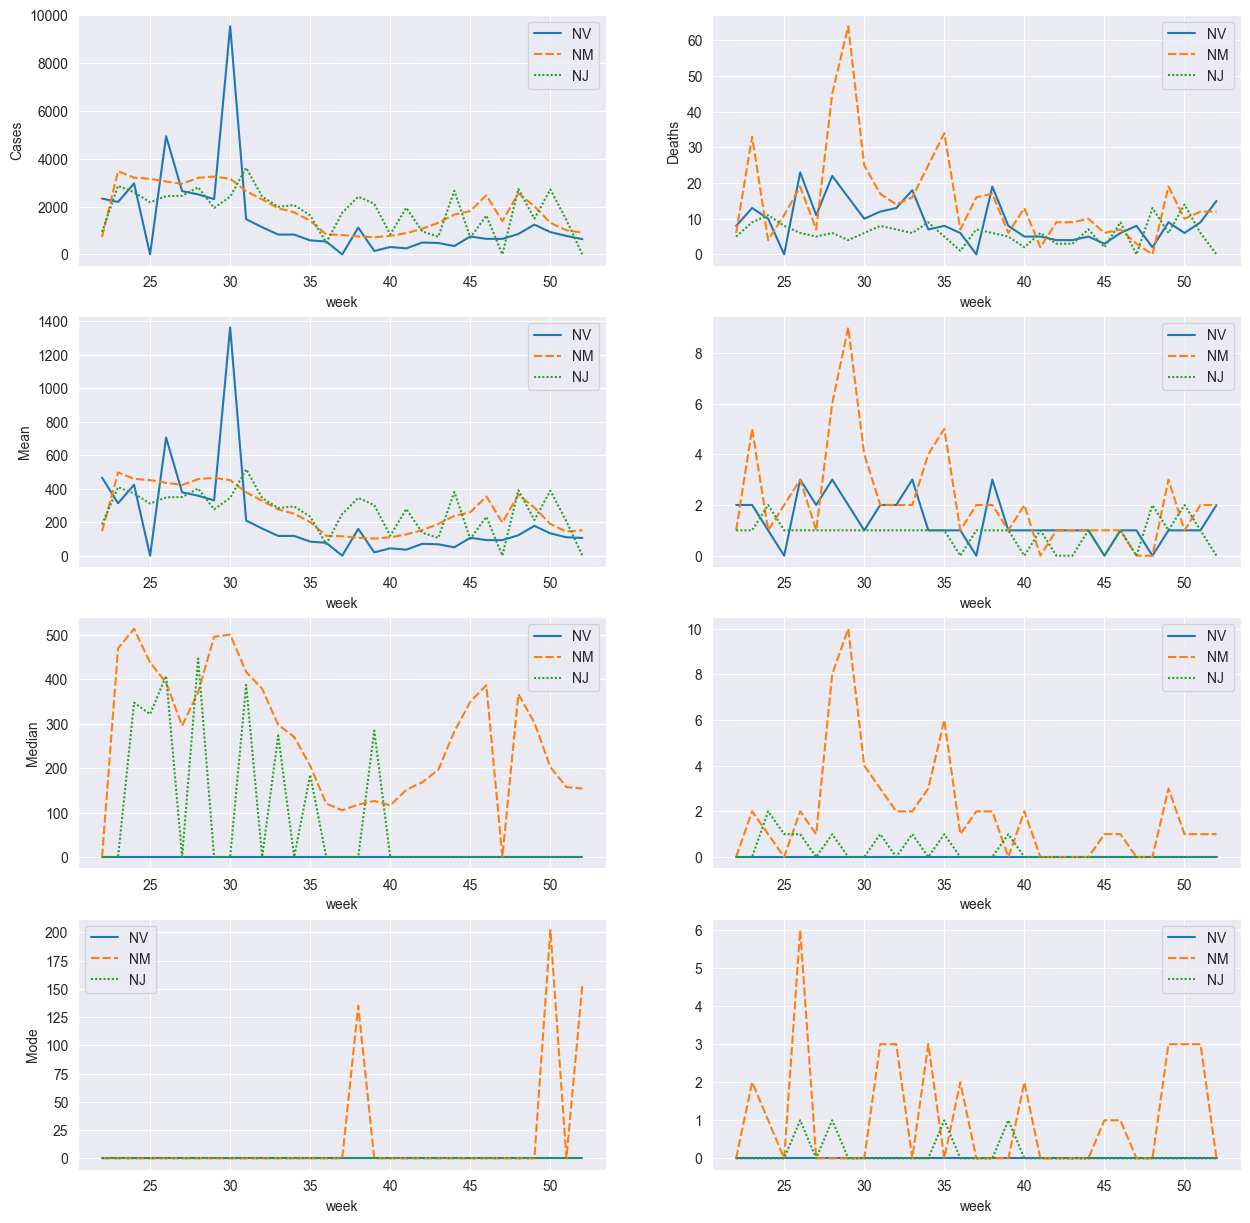

In [501]:
fig, ax = plt.subplots(4, 2, figsize=(15, 15))

ax[0,0].set_ylabel('Cases')
ax[0,1].set_ylabel('Deaths')
ax[1,0].set_ylabel('Mean')
ax[2,0].set_ylabel('Median')
ax[3,0].set_ylabel('Mode')
sns.lineplot(data=states_covid_cases_time_series_weekly_sum_df, ax=ax[0,0])
sns.lineplot(data=states_covid_deaths_time_series_weekly_sum_df, ax=ax[0,1])
sns.lineplot(data=states_covid_cases_time_series_weekly_mean_df, ax=ax[1,0])
sns.lineplot(data=states_covid_deaths_time_series_weekly_mean_df, ax=ax[1,1])
sns.lineplot(data=states_covid_cases_time_series_weekly_median_df, ax=ax[2,0])
sns.lineplot(data=states_covid_deaths_time_series_weekly_median_df, ax=ax[2,1])
sns.lineplot(data=states_covid_cases_time_series_weekly_mode_df, ax=ax[3,0])
sns.lineplot(data=states_covid_deaths_time_series_weekly_mode_df, ax=ax[3,1])

In [502]:
us_covid_time_series_df = normalize(get_us_new_cases_and_deaths(), pop_df['population'].sum(), 10000)
us_weekly_covid_sum = get_weekly_statistics(us_covid_time_series_df, 'sum')
us_weekly_covid_mean = get_weekly_statistics(us_covid_time_series_df, 'mean')
us_weekly_covid_median = get_weekly_statistics(us_covid_time_series_df, 'median')
us_weekly_covid_mode = get_weekly_statistics(us_covid_time_series_df, 'mode')

<Axes: xlabel='week', ylabel='Deaths'>

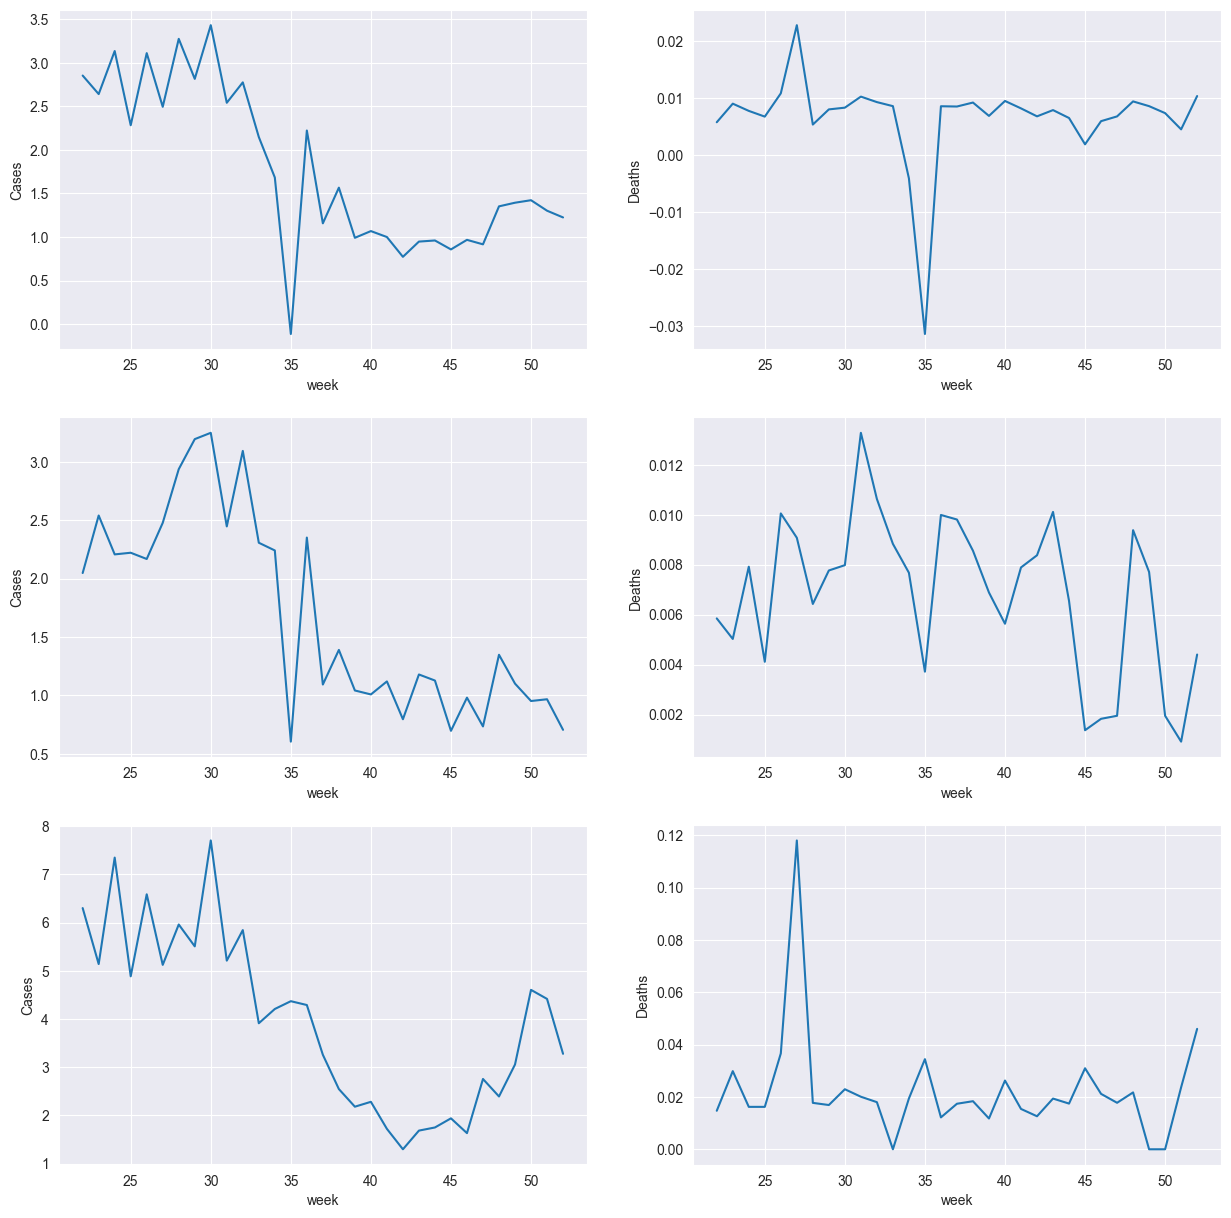

In [503]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
sns.lineplot(data=us_weekly_covid_mean['Cases'], ax=ax[0,0])
sns.lineplot(data=us_weekly_covid_mean['Deaths'], ax=ax[0,1])
sns.lineplot(data=us_weekly_covid_median['Cases'], ax=ax[1,0])
sns.lineplot(data=us_weekly_covid_median['Deaths'], ax=ax[1,1])
sns.lineplot(data=us_weekly_covid_mode['Cases'], ax=ax[2,0])
sns.lineplot(data=us_weekly_covid_mode['Deaths'], ax=ax[2,1])


In [504]:
covid_state_1_cases_df = pd.read_csv('Team_work/data/covid_confirmed_usafacts.csv')
covid_state_1_deaths_df = pd.read_csv('Team_work/data/covid_deaths_usafacts.csv')
covid_state_1_cases_df = covid_state_1_cases_df[covid_state_1_cases_df['countyFIPS'] != 0]
covid_state_1_deaths_df = covid_state_1_deaths_df[covid_state_1_deaths_df['countyFIPS'] != 0]
covid_state_1_cases_df = covid_state_1_cases_df.drop_duplicates()
covid_state_1_deaths_df = covid_state_1_deaths_df.drop_duplicates()
covid_state_1_cases_df = covid_state_1_cases_df[covid_state_1_cases_df['State'] == STATES[0]]
covid_state_1_deaths_df = covid_state_1_deaths_df[covid_state_1_deaths_df['State'] == STATES[0]]
covid_state_1_counties_cases_df = covid_state_1_cases_df.drop(['County Name', 'State', 'StateFIPS'], axis=1)
covid_state_1_counties_deaths_df = covid_state_1_deaths_df.drop(['County Name', 'State', 'StateFIPS'], axis=1)
covid_state_1_counties_cases_df = covid_state_1_counties_cases_df.set_index('countyFIPS')
covid_state_1_counties_deaths_df = covid_state_1_counties_deaths_df.set_index('countyFIPS')
covid_state_1_counties_cases_df.columns = pd.to_datetime(covid_state_1_counties_cases_df.columns)
covid_state_1_counties_deaths_df.columns = pd.to_datetime(covid_state_1_counties_deaths_df.columns)
covid_state_1_counties_cases_df = covid_state_1_counties_cases_df.T
covid_state_1_counties_deaths_df = covid_state_1_counties_deaths_df.T
covid_state_1_counties_cases_df = covid_state_1_counties_cases_df[covid_state_1_counties_cases_df.index.to_series().between(LOWER_INTERVAL_BOUND, UPPER_INTERVAL_BOUND)]
covid_state_1_counties_deaths_df = covid_state_1_counties_deaths_df[covid_state_1_counties_deaths_df.index.to_series().between(LOWER_INTERVAL_BOUND, UPPER_INTERVAL_BOUND)]
covid_state_1_counties_cases_df = covid_state_1_counties_cases_df.diff().drop(LOWER_INTERVAL_BOUND)
covid_state_1_counties_deaths_df = covid_state_1_counties_deaths_df.diff().drop(LOWER_INTERVAL_BOUND)
covid_state_1_counties_cases_weekly_df = covid_state_1_counties_cases_df.groupby(covid_state_1_counties_cases_df.index.isocalendar().week).mean().round()
covid_state_1_counties_deaths_weekly_df = covid_state_1_counties_deaths_df.groupby(covid_state_1_counties_deaths_df.index.isocalendar().week).mean().round()
covid_state_1_counties_cases_weekly_sum_df = covid_state_1_counties_cases_weekly_df.agg(np.sum, axis=0)
covid_state_1_counties_deaths_weekly_sum_df = covid_state_1_counties_deaths_weekly_df.agg(np.sum, axis=0)
covid_state_1_counties_cases_weekly_max = covid_state_1_counties_cases_weekly_sum_df.sort_values(ascending=False).iloc[:3]
covid_state_1_counties_deaths_weekly_max = covid_state_1_counties_deaths_weekly_sum_df.sort_values(ascending=False).iloc[:3]
covid_state_1_counties_cases_weekly_max = [fips for fips in covid_state_1_counties_cases_weekly_max.index]
covid_state_1_counties_deaths_weekly_max = [fips for fips in covid_state_1_counties_deaths_weekly_max.index]
print(covid_state_1_counties_cases_weekly_max)
print(covid_state_1_counties_deaths_weekly_max)

[6037, 6073, 6059]
[6037, 6059, 6071]


In [505]:
covid_counties_oi_cases_df = covid_state_1_counties_cases_df
covid_counties_oi_cases_df.columns = covid_counties_oi_cases_df.columns.to_list()
covid_counties_oi_cases_df = covid_counties_oi_cases_df[covid_state_1_counties_cases_weekly_max]
covid_counties_oi_cases_weekly_df = covid_counties_oi_cases_df.groupby(covid_counties_oi_cases_df.index.isocalendar().week).sum()
cases_county_names = [get_county_name_by_fips(name) for name in covid_state_1_counties_cases_weekly_max]
deaths_county_names = [get_county_name_by_fips(name) for name in covid_state_1_counties_deaths_weekly_max]
covid_counties_oi_cases_weekly_df.columns = cases_county_names
covid_counties_oi_deaths_df = covid_state_1_counties_deaths_df
covid_counties_oi_deaths_df.columns = covid_counties_oi_deaths_df.columns.to_list()
covid_counties_oi_deaths_df = covid_counties_oi_deaths_df[covid_state_1_counties_deaths_weekly_max]
covid_counties_oi_deaths_weekly_df = covid_counties_oi_deaths_df.groupby(covid_counties_oi_deaths_df.index.isocalendar().week).sum()
covid_counties_oi_deaths_weekly_df.columns = deaths_county_names

<Axes: xlabel='week', ylabel='Deaths'>

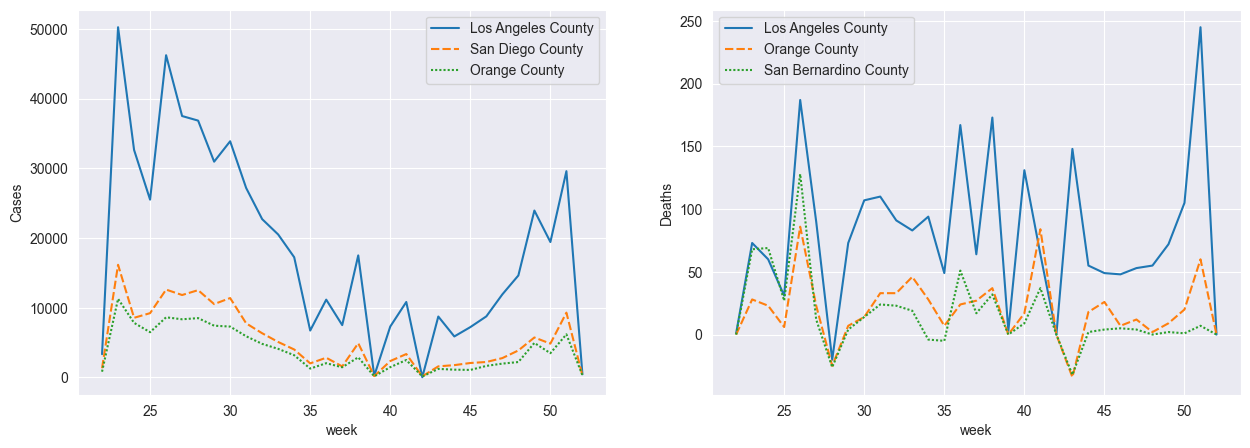

In [506]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_ylabel('Cases')
ax[1].set_ylabel('Deaths')
sns.lineplot(data=covid_counties_oi_cases_weekly_df, ax=ax[0])
sns.lineplot(data=covid_counties_oi_deaths_weekly_df, ax=ax[1])

In [507]:
covid_counties_oi_cases_weekly_df[cases_county_names[0]] = normalize(covid_counties_oi_cases_weekly_df[cases_county_names[0]], get_county_population(STATES[0], covid_state_1_counties_cases_weekly_max[0])).round()
covid_counties_oi_cases_weekly_df[cases_county_names[1]] = normalize(covid_counties_oi_cases_weekly_df[cases_county_names[1]], get_county_population(STATES[0], covid_state_1_counties_cases_weekly_max[1])).round()
covid_counties_oi_cases_weekly_df[cases_county_names[2]] = normalize(covid_counties_oi_cases_weekly_df[cases_county_names[2]], get_county_population(STATES[0], covid_state_1_counties_cases_weekly_max[2])).round()
covid_counties_oi_deaths_weekly_df[deaths_county_names[0]] = normalize(covid_counties_oi_deaths_weekly_df[deaths_county_names[0]], get_county_population(STATES[0], covid_state_1_counties_deaths_weekly_max[0])).round()
covid_counties_oi_deaths_weekly_df[deaths_county_names[1]] = normalize(covid_counties_oi_deaths_weekly_df[deaths_county_names[1]], get_county_population(STATES[0], covid_state_1_counties_deaths_weekly_max[1])).round()
covid_counties_oi_deaths_weekly_df[deaths_county_names[2]] = normalize(covid_counties_oi_deaths_weekly_df[deaths_county_names[2]], get_county_population(STATES[0], covid_state_1_counties_deaths_weekly_max[2])).round()

[None, None]

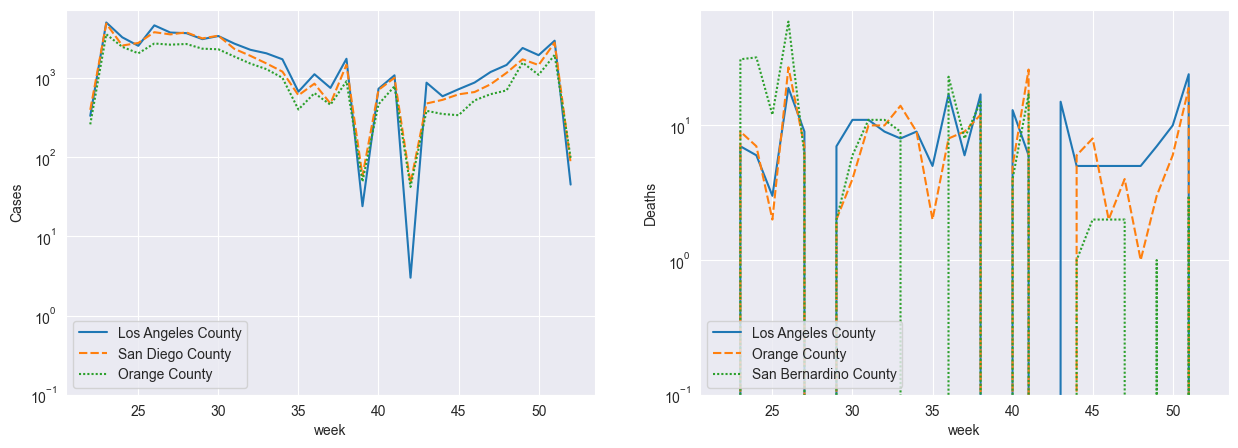

In [508]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_ylabel('Cases')
ax[1].set_ylabel('Deaths')
cases_plot = sns.lineplot(data=covid_counties_oi_cases_weekly_df, ax=ax[0])
deaths_plot = sns.lineplot(data=covid_counties_oi_deaths_weekly_df, ax=ax[1])
cases_plot.set(yscale='log', ybound=0.1)
deaths_plot.set(yscale='log', ybound=0.1)